In [97]:
import praw
import json
import pandas as pd


#load the json file with the login info
with open('secret_token.json') as i:
    login = json.load(i)

#use python reddit api wrapper to pull data
reddit = praw.Reddit(client_id=login['client_id'],
                     client_secret=login['client_secret'],
                     user_agent=login['user_agent'],
                     username=login['username'],
                     password=login['password']
                     )
    

In [98]:
#this code block should remain seperate from everything as the runtime on an i9 was almost 1 minute
#this is needed however to find the top posts from alltime on each subreddit
#get top posts from each different game console subreddits to see what the highest upvoted submissions/posts are
#create lists to store the post information so we can convert them to a dataframe later
PS5_posts = []
xboxone_posts = []
NintendoSwitch_posts = []


#create the subreddit instance
#change the subreddit's name here to create new instance to pull info
#pull the submissions from the subreddits
for i in reddit.subreddit('PS5').top(time_filter='all', limit=900):
    PS5_posts.append([
            i.id, i.author, i.title, i.score, i.num_comments, i.selftext, i.created, i.pinned, i.total_awards_received
        ])

#pull the submissions from the subreddits
for i in reddit.subreddit('xboxone').top(time_filter='all', limit=900):
    xboxone_posts.append([
            i.id, i.author, i.title, i.score, i.num_comments, i.selftext, i.created, i.pinned, i.total_awards_received,
        ])

#pull the submissions from the subreddits
for i in reddit.subreddit('NintendoSwitch').top(time_filter='all', limit=900):
    NintendoSwitch_posts.append([
            i.id, i.author, i.title, i.score, i.num_comments, i.selftext, i.created, i.pinned, i.total_awards_received,
        ])

In [99]:
#imports
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import emoji
import pickle
import re
import seaborn as sns
#for language processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
#for dimensionality reduction
from sklearn.decomposition import PCA
#for plotting
import plotly.express as px
import matplotlib.pyplot as plt
#for relabeling purposes
from scipy.stats import mode


#convert all the lists to dataframes
ps5_df = pd.DataFrame(PS5_posts, columns=['id','author','title','score','num_comments', 'selftext','created','pinned','total_awards_received'])
xbox_df = pd.DataFrame(xboxone_posts, columns=['id','author','title','score','num_comments', 'selftext','created','pinned','total_awards_received'])
nintendo_df = pd.DataFrame(NintendoSwitch_posts, columns=['id','author','title','score','num_comments', 'selftext','created','pinned','total_awards_received'])

#import the dataset we shared together so that we're all using the same data
df = pd.read_csv('../project/console_reddit.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

#make a copy of the original df for the gridsearch later
df1 = df

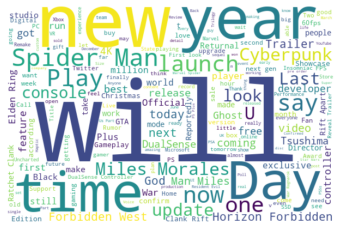

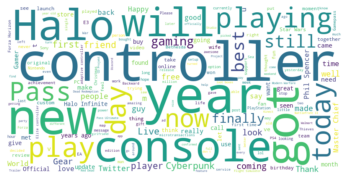

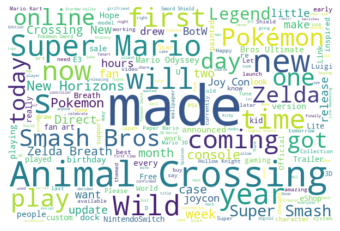

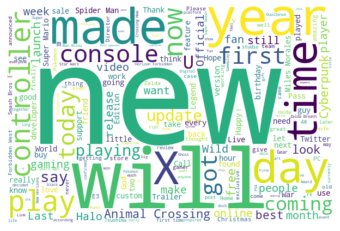

In [100]:
#cell for creation of the word clouds to visualize some keys talking point in among top posts
#create a wordclud function that takes in a wordcloud and displays it
def wordcloud_creator(wordcloud):
    #show the wordcloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

#create some stopwords so we can see what some common talking points are
stopwords_ps5 = set(STOPWORDS)
stopwords_ps5.update(['PS5', 'Playstation', 'Sony','game','games','S','PS4'])

stopwords_xbox = set(STOPWORDS)
stopwords_xbox.update(['Xbox','Microsoft','S','X','one','game','games','series'])

stopwords_nintendo = set(STOPWORDS)
stopwords_nintendo.update(['Nintendo','Switch','game','games'])

stopwords_all = set(STOPWORDS)
stopwords_all.update(['PS5','Playstation','Sony','Xbox','Microsoft','S','Nintendo','Switch','game','games', 'one', 'S','PS4','series'])

#generate wordclouds for each subreddit and the combination of the 3
wordcloud_ps5 = wordcloud_creator(WordCloud(stopwords=stopwords_ps5, width=600, height=400, background_color='white').generate(' '.join(ps5_df['title'])))
wordcloud_xbox = wordcloud_creator(WordCloud(stopwords=stopwords_xbox, width=800, height=400, background_color='white').generate(' '.join(xbox_df['title'])))
wordcloud_nintendo = wordcloud_creator(WordCloud(stopwords=stopwords_nintendo, width=600, height=400, background_color='white').generate(' '.join(nintendo_df['title'])))
wordcloud_all = wordcloud_creator(WordCloud(stopwords=stopwords_all, width=600, height=400, background_color='white').generate(' '.join(df['title'])))


In [101]:
#code that removes all unnecessary characters to get a more accurate sense of what words are more important
#for our classification models

#### functions relate to emoji ####
with open('Emoticon_Dict.p', 'rb') as fp:
    Emoticon_Dict = pickle.load(fp)

def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in Emoticon_Dict) + u')')
    return emoticon_pattern.sub(r'', text)

#### functions relate to lemmatization ####
lemmatizer = WordNetLemmatizer()
# Lemmatize with POS Tag
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def Lemmatization(string):
    """converts words in a string to their base form"""
    
    word_list = nltk.word_tokenize(string) # Tokenize: Split the sentence into words
    output = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_list]) # lemmatize each word and rejoin the words to a senetence
    return output

#### functions relate to stop word ####
stop_words = stopwords.words("english")
stop_words.append('game')
stop_words.append('games')

def StopWords(string):
    """remove stop word in a string"""
    word_list = nltk.word_tokenize(string) # Tokenize: Split the sentence into words
    temp = [i for i in word_list if i.lower() not in stop_words ] # append words in `temp` list if t
    output = ' '.join(temp) # lemmatize each word and rejoin the words to a senetence
    return output

df['title'] =[ emoji.demojize(i, delimiters=(" ", " "))  for i in df['title']] # convert emoji to word
df['title'] =[ re.sub('http\S+','',i) for i in df['title']] #remove urls
df['title'] =[ re.sub('&\w+;','',i) for i in df['title']] #remove special character
df['title'] =[ re.sub('\n',' ',i) for i in df['title']] #remove control chracters
#df['title'] =[ re.sub('[’']'\w+','',i) for i in df['title']]
df['title'] =[ re.sub('\d+',' ',i) for i in df['title']] #remove digit character
df['title'] =[ re.sub('[^\w\s]',' ',i) for i in df['title']] # remove all punctuations
df['title'] =[ re.sub('\s{2,}',' ',i) for i in df['title']]# remove extra space
df['title'] =[ re.sub('^\s','',i) for i in df['title']]# remove space at the beginning of the string
df['title'] =[ re.sub('\s$','',i) for i in df['title']]# remove space at the end of the string 
df['title'] =[ i.lower() for i in df['title']]# convert all the character to lower cases

In [102]:
#create a column with dummy values to label our data so we can pass it through our model
df['label'] = df['source'].replace(["Playstation", "Xbox", "Nintendo"], [0,1,2])
#0 for PS
#1 for Xbox
#2 for Nintendo

#proccess data here
# Remove stop words and lemmatization
df['title'] = df['title'].map(lambda x:Lemmatization(x))
df['title'] = df['title'].map(lambda x:StopWords(x))


#use a CountVectorizer to make a bag of words
vectorizer = CountVectorizer(min_df=2)
X = df['title']
X = vectorizer.fit_transform(X)
X = pd.DataFrame(data = X.toarray())
X.head()


,0,1,2,3,4,5,6,7,8,9,...,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


              precision    recall  f1-score   support

    Nintendo       0.97      0.29      0.44       900
 Playstation       0.41      0.98      0.58       900
        Xbox       0.94      0.31      0.47       900

    accuracy                           0.53      2700
   macro avg       0.78      0.53      0.50      2700
weighted avg       0.78      0.53      0.50      2700

The fowlkes mallows score is: 0.504804886780558


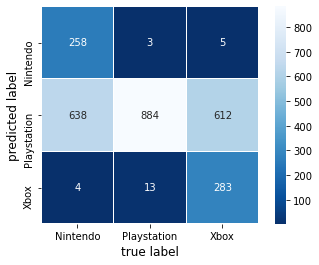

In [103]:
from sklearn.metrics import classification_report, fowlkes_mallows_score, confusion_matrix
from sklearn.cluster import KMeans

# k-mean cluster
kmeans = KMeans(n_clusters = 3, random_state=180).fit(X)
clusters = kmeans.predict(X)

# match each learned cluster label with true labels
labels = np.zeros_like(clusters)
for i in range (3):
    mask = (clusters == i)
    labels[mask] = mode(df['label'][mask])[0]

# change the label to source name
df['pred_cluster'] = labels
df['pred_cluster']= df['pred_cluster'].replace([0,1,2],['Playstation', 'Xbox', 'Nintendo'])

#print a classification report for out kmeans model
print(classification_report(df['source'],df['pred_cluster']))

#print a fowlkes mallows score for our kmeans model
print('The fowlkes mallows score is: {}'.format(fowlkes_mallows_score(df['source'],df['pred_cluster'])))

# plot confusion matrix
mat = confusion_matrix(df['source'],df['pred_cluster'])
sns.heatmap(mat.T, 
            square=True, 
            annot=True, 
            fmt='d', 
            linewidths=.1, 
            cmap="Blues_r",
            xticklabels=['Nintendo', 'Playstation', 'Xbox'], 
            yticklabels=['Nintendo', 'Playstation', 'Xbox'])
plt.xlabel('true label',fontsize=12)
plt.ylabel('predicted label',fontsize=12);

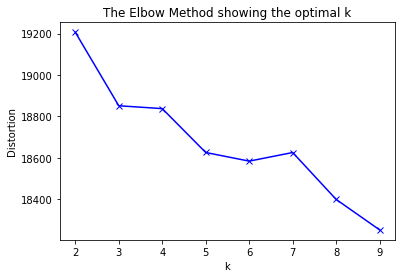

In [104]:
#use elbow method to see optimal cluster for our model
#create variables
distortions = []
K_dis = []
K = range(2,10)

#create loop for elbow method
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=100).fit(X)
    distortions.append(kmeanModel.inertia_) # get the mean value of Sum of squared distances 

#plot the elbow method
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [105]:

X = df['title']
X = vectorizer.fit_transform(X)

pca = PCA(n_components=2, random_state=42) # initialize PCA with 2 components
pca_vecs = pca.fit_transform(X.toarray()) # pass our X to the pca and store the reduced vectors into pca_vecs
# save our two dimensions into x0 and x1
x = pca_vecs[:, 0]
y = pca_vecs[:, 1]

df['x'] = x
df['y'] = y
fig = px.scatter(df, x="x", y="y", color='source',title = "Top All Time Posts From Subreddits ")
fig.show()


In [106]:
fig = px.scatter(df, x="x", y="y", color='pred_cluster',title = "Three Clusters For Subreddits")
fig.show()

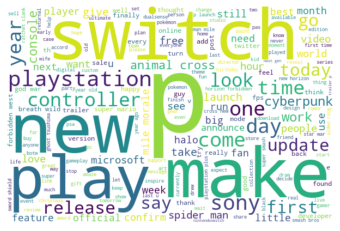

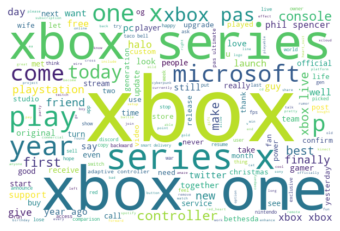

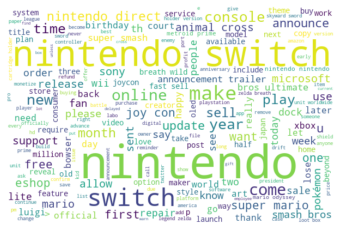

In [107]:
#generate wordclouds for predicted clusters
wordcloud_ps5_1 = wordcloud_creator(WordCloud(background_color='white', width=600, height=400).generate(' '.join(df[df['pred_cluster']=='Playstation'].title)))
wordcloud_xbox_1 = wordcloud_creator(WordCloud(background_color='white', width=600, height=400).generate(' '.join(df[df['pred_cluster']=='Xbox'].title)))
wordcloud_nintendo_1 = wordcloud_creator(WordCloud(background_color='white', width=600, height=400).generate(' '.join(df[df['pred_cluster']=='Nintendo'].title)))

In [108]:
# import libraries
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

#create label columns for the df
df1['labels'] = df1['source'].replace(["Playstation", "Xbox", "Nintendo"], [0,1,2])
#0 for PS
#1 for Xbox
#2 for Nintendo

#create train and test splits of our data to pass through our grid search model
x_train, x_test, y_train, y_test = train_test_split(df['title'], df1['labels'], test_size=0.3, random_state=42)

#create a Pipeline for TF-IDF with Logistic Regression model just to make the code a lot cleaner
pipe = Pipeline([('tfidf', TfidfVectorizer()), ('logreg', LogisticRegression())])

# Parameters for TF-IDF vectorization for GridSearch
pipeline_params = {
    'tfidf__max_features': [1000, 2000],
    'tfidf__stop_words': [None, 'english'],}

#Initalize our gridsearch and fit the data to it
grid_model = GridSearchCV(pipe, param_grid = pipeline_params, cv=5)
grid_model.fit(x_train,y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'tfidf__max_features': [1000, 2000],
                         'tfidf__stop_words': [None, 'english']})

              precision    recall  f1-score   support

           0       0.73      0.81      0.77       272
           1       0.75      0.77      0.76       252
           2       0.92      0.81      0.86       286

    accuracy                           0.80       810
   macro avg       0.80      0.80      0.80       810
weighted avg       0.80      0.80      0.80       810

The fowlkes mallows score is: 0.6599488723491767


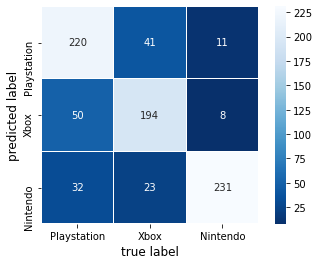

In [109]:

#predict our titles from the test data
pred_test = grid_model.predict(x_test)

#create a new dataframe from our test data
grid_df = pd.DataFrame({'predicted_source': pred_test, 'title': x_test})
grid_df['predicted_source'].replace([0,1,2],['Playstation', 'Xbox', 'Nintendo'], inplace=True)

#print the classification report for the gridsearch model
print(classification_report(y_test, pred_test))

#print the fowlkes mallows score for the grid search model
print('The fowlkes mallows score is: {}'.format(fowlkes_mallows_score(y_test, pred_test)))

#create a confusion matrix to plot a heatmap
grid_matrix = confusion_matrix(y_test, pred_test)

sns.heatmap(grid_matrix, 
            square=True, 
            annot=True, 
            fmt='d', 
            linewidths=.1, 
            cmap="Blues_r",
            xticklabels=['Playstation', 'Xbox', 'Nintendo'], 
            yticklabels=['Playstation', 'Xbox', 'Nintendo'])
plt.xlabel('true label',fontsize=12)
plt.ylabel('predicted label',fontsize=12);


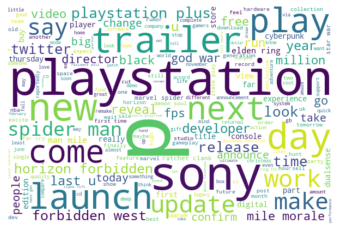

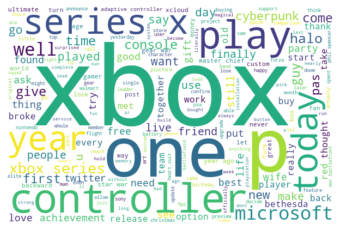

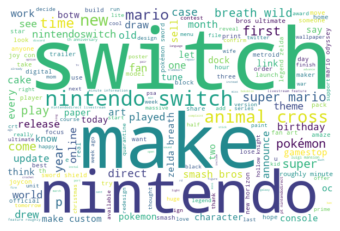

In [110]:
#create wordclouds for the gridsearch model
wordcloud_ps5_2 = wordcloud_creator(WordCloud(background_color='white', width=600, height=400).generate(' '.join(grid_df[grid_df['predicted_source']=='Playstation'].title)))
wordcloud_xbox_2 = wordcloud_creator(WordCloud(background_color='white', width=600, height=400).generate(' '.join(grid_df[grid_df['predicted_source']=='Xbox'].title)))
wordcloud_nintendo_2 = wordcloud_creator(WordCloud(background_color='white', width=600, height=400).generate(' '.join(grid_df[grid_df['predicted_source']=='Nintendo'].title)))

In [111]:
#create some test data to run through both the unsupervised kmean and then the supervised gridsearch
sentances = {'elden ring is an 10/10 game!': 'playstation', 'paper mario is fun!': 'nintendo', 'halo infinite has major desync issues' : 'xbox',
            'metroid dread the best metroid ever?': 'nintendo', 'playstation  5 has record sales month': 'playstation', 'new xbox controller looks awesome' : 'xbox',
            'last of us 2 has an amazing physics engine!!': 'playstation', 'forza horizon 5 has amazing customization!': 'xbox', 'botw 2 where are you?': 'nintendo',
            'animal crossing introduces dlc for nintendo online subscribers': 'nintendo', 'xbox purchases bethesda': 'xbox', 'final fantasy 16 trailer': 'playstation',
            'playstation support is the worst for any large tech company': 'playstation', 'xbox support is super helpful': 'xbox', 'nintendo is super anti-consumer': 'nintendo'}

test_df = pd.DataFrame(sentances.items(), columns=['title','source'])

#create a column with dummy values to label our data so we can pass it through our model
test_df['label'] = test_df['source'].replace(["playstation", "xbox", "nintendo"], [0,1,2])
#0 for PS
#1 for Xbox
#2 for Nintendo

#proccess data here
# Remove stop words and lemmatization
test_df['title'] = test_df['title'].map(lambda x:Lemmatization(x))
test_df['title'] = test_df['title'].map(lambda x:StopWords(x))


#use a CountVectorizer to make a bag of words
X_new = test_df['title']
X_new = vectorizer.transform(X_new)
X_new = pd.DataFrame(X_new.toarray())
X_new.head()

,0,1,2,3,4,5,6,7,8,9,...,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


              precision    recall  f1-score   support

    nintendo       1.00      0.40      0.57         5
 playstation       0.50      1.00      0.67         5
        xbox       1.00      0.60      0.75         5

    accuracy                           0.67        15
   macro avg       0.83      0.67      0.66        15
weighted avg       0.83      0.67      0.66        15

The fowlkes mallows score is: 0.469476477861571


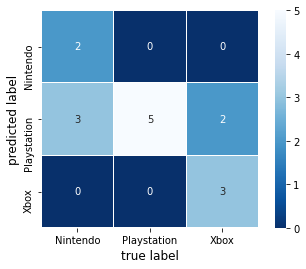

In [112]:
# k-mean cluster
clusters = kmeans.predict(X_new)

# match each learned cluster label with true labels
labels = np.zeros_like(clusters)
for i in range (3):
    mask = (clusters == i)
    labels[mask] = mode(test_df['label'][mask])[0]

# change the label to source name
test_df['pred_cluster'] = labels
test_df['pred_cluster']= test_df['pred_cluster'].replace([0,1,2],['playstation', 'xbox', 'nintendo'])

#print a classification report for out kmeans model
print(classification_report(test_df['source'],test_df['pred_cluster']))

#print a fowlkes mallows score for our kmeans model
print('The fowlkes mallows score is: {}'.format(fowlkes_mallows_score(test_df['source'],test_df['pred_cluster'])))

# plot confusion matrix
mat = confusion_matrix(test_df['source'],test_df['pred_cluster'])
sns.heatmap(mat.T, 
            square=True, 
            annot=True, 
            fmt='d', 
            linewidths=.1, 
            cmap="Blues_r",
            xticklabels=['Nintendo', 'Playstation', 'Xbox'], 
            yticklabels=['Nintendo', 'Playstation', 'Xbox'])
plt.xlabel('true label',fontsize=12)
plt.ylabel('predicted label',fontsize=12);

Overall what we observed in our testing with an unsupervised model is that it can predict the correct game subreddit it came from a little over 50 percent
of the time. Compairing it to a a supervised model we observed a much higher precision as obviously the model was trained with labels. With text data
being vectorized we observed a large amount of data points being grouped together which made it hard for the unsupervised model to accurately predict the correct
subreddits. In conclusion we observed some overlap with the content of our data between subreddits and our model did better than we expected, as we
thought we would get well below 50 percent.